In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import h5py
import pandas as pd
import seaborn as sns
from pandas import DataFrame

import tensorflow as tf
from tensorflow.keras import layers, models
import random

# Set a specific random seed
random.seed(42)

In [2]:
import torch
torch.cuda.is_available()
torch.cuda.get_device_name(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.tensor([1.0, 2.0, 3.0])
x = x.to(device)
print(x.device)
torch.cuda.get_device_name(0)

cuda:0


'NVIDIA GeForce RTX 2060'

In [3]:
# Time tracking, Operation time (min):  0.003
filename="N-CMAPSS_DS02-006.h5"
t = time.process_time()  

# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print('')
print("Operation time (min): " , (time.process_time()-t)/60)
print('')
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))


Operation time (min):  0.053125

W shape: (6517190, 4)
X_s shape: (6517190, 14)
X_v shape: (6517190, 14)
T shape: (6517190, 10)
A shape: (6517190, 4)


In [13]:
df_W = DataFrame(data=W, columns=W_var)
df_X_s_parameters = DataFrame(data=X_s, columns=X_s_var)
df_X_v_parameters = DataFrame(data=X_v, columns=X_v_var)
df_T = DataFrame(data=T, columns=T_var)
df_Y = DataFrame(data=Y, columns=['RUL'])
df_A = DataFrame(data=A, columns=A_var)
df_all_units=pd.concat([df_W,df_A,df_X_s_parameters,df_X_v_parameters,df_T,df_Y],axis=1)
def prepare_data(dataframe,list_of_columns_to_drop):
    dataframe=dataframe.drop(columns=list_of_columns_to_drop)
    return dataframe
def data_test_train_splitter(DataFrame,train_idx,test_idx,list_of_columns_to_drop):
    train_df=prepare_data(DataFrame.loc[DataFrame["unit"].isin(train_idx)],list_of_columns_to_drop)
    test_df=prepare_data(DataFrame.loc[DataFrame["unit"].isin(test_idx)],list_of_columns_to_drop)
    return (train_df,test_df)

In [14]:
train_idx=[16]
test_idx=[14,11,15]
# list_of_columns_to_drop=["alt","Mach","TRA",'fan_eff_mod','fan_flow_mod','LPC_eff_mod','HPC_eff_mod','HPC_flow_mod','HPT_flow_mod','LPT_eff_mod','LPT_flow_mod']

list_of_columns_to_drop=["alt","Mach","TRA","fan_eff_mod","fan_flow_mod","LPC_eff_mod","LPC_flow_mod","HPC_flow_mod","HPC_eff_mod","HPT_flow_mod"]
train,test=data_test_train_splitter(df_all_units,train_idx,test_idx,list_of_columns_to_drop)
# train.drop(columns=["unit","Fc"])
# test.drop(columns=["unit","Fc"])
train  

,T2,unit,cycle,Fc,hs,T24,T30,T48,T50,P15,...,W48,W50,SmFan,SmLPC,SmHPC,phi,HPT_eff_mod,LPT_eff_mod,LPT_flow_mod,RUL
2839273,503.721197,16.0,1.0,3.0,1.0,602.809026,1445.734091,1831.247582,1234.668125,16.004249,...,219.132512,231.882086,16.755149,9.826825,25.205333,42.167109,-0.000748,-0.000499,-0.000470,62
2839274,503.699197,16.0,1.0,3.0,1.0,602.884699,1445.729730,1830.328855,1233.775609,16.004450,...,219.145580,231.898897,16.747632,9.812432,25.243954,42.128645,-0.000748,-0.000499,-0.000470,62
2839275,503.682048,16.0,1.0,3.0,1.0,602.850026,1445.623942,1830.356293,1233.817761,15.999599,...,219.061447,231.810175,16.751288,9.804538,25.239399,42.133718,-0.000748,-0.000499,-0.000470,62
2839276,503.653483,16.0,1.0,3.0,1.0,602.817989,1445.560836,1830.231656,1233.717364,15.995012,...,219.009495,231.755178,16.751436,9.806258,25.240772,42.130588,-0.000748,-0.000499,-0.000470,62
2839277,503.645699,16.0,1.0,3.0,1.0,602.803554,1445.513032,1830.195152,1233.683058,15.992129,...,218.963946,231.706993,16.754685,9.804464,25.240621,42.130812,-0.000748,-0.000499,-0.000470,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3604563,502.759104,16.0,63.0,3.0,0.0,555.135733,1232.870547,1468.184069,1089.496435,13.519393,...,137.547188,145.687444,19.001082,6.042239,31.538067,34.080248,-0.008968,-0.005504,-0.017672,0
3604564,502.756750,16.0,63.0,3.0,0.0,554.678067,1229.818158,1459.263290,1084.383871,13.498591,...,136.681546,144.774412,18.987135,6.006830,31.808141,33.798049,-0.008968,-0.005504,-0.017672,0
3604565,502.770538,16.0,63.0,3.0,0.0,554.157953,1227.944149,1458.169108,1085.181024,13.476994,...,135.983569,144.034985,18.984340,6.002011,31.754596,33.824353,-0.008968,-0.005504,-0.017672,0
3604566,502.800780,16.0,63.0,3.0,0.0,553.690880,1224.529086,1448.463089,1079.716205,13.456842,...,135.009254,143.009394,18.971948,5.944589,32.050241,33.521120,-0.008968,-0.005504,-0.017672,0


In [14]:

test

,T2,unit,cycle,Fc,hs,T24,T30,T48,T50,P15,...,W48,W50,SmFan,SmLPC,SmHPC,phi,HPT_eff_mod,LPT_eff_mod,LPT_flow_mod,RUL
5263447,503.176696,11.0,1.0,3.0,1.0,601.369822,1441.086963,1822.407728,1230.069061,15.900837,...,217.085529,229.722454,16.745510,9.812495,25.345244,41.971419,-0.000698,-0.000294,-0.000493,58
5263448,503.192949,11.0,1.0,3.0,1.0,601.381211,1441.055436,1822.376094,1230.025551,15.900690,...,217.058720,229.694212,16.751997,9.806257,25.346932,41.971470,-0.000698,-0.000294,-0.000493,58
5263449,503.203187,11.0,1.0,3.0,1.0,601.392126,1441.063188,1822.350721,1229.965758,15.899810,...,217.043190,229.677650,16.758975,9.804009,25.348326,41.969940,-0.000698,-0.000294,-0.000493,58
5263450,503.158580,11.0,1.0,3.0,1.0,601.348485,1440.964145,1822.141800,1229.809741,15.894349,...,216.981145,229.612403,16.755378,9.803649,25.352080,41.964794,-0.000698,-0.000294,-0.000493,58
5263451,503.105629,11.0,1.0,3.0,1.0,601.285695,1440.852510,1822.019760,1229.732630,15.886351,...,216.890123,229.516137,16.753262,9.806697,25.351024,41.963540,-0.000698,-0.000294,-0.000493,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6517185,497.040848,15.0,67.0,2.0,0.0,544.098139,1203.357895,1421.337905,1077.482738,12.837452,...,127.892362,135.472311,16.461637,6.788187,32.223755,33.147993,-0.010829,-0.011415,-0.010910,0
6517186,497.035821,15.0,67.0,2.0,0.0,544.035020,1203.472392,1422.772517,1078.697718,12.835965,...,127.892061,135.471205,16.451330,6.803624,32.156314,33.208375,-0.010829,-0.011415,-0.010910,0
6517187,497.043961,15.0,67.0,2.0,0.0,544.055787,1203.507712,1422.445115,1078.410015,12.838463,...,127.930662,135.511892,16.444379,6.810375,32.172889,33.191835,-0.010829,-0.011415,-0.010910,0
6517188,497.047255,15.0,67.0,2.0,0.0,544.060142,1203.529870,1422.576000,1078.539340,12.839843,...,127.943031,135.524933,16.435526,6.810105,32.168495,33.197271,-0.010829,-0.011415,-0.010910,0


# SCALING TRAIN


In [15]:
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import StandardScaler

# Assuming df is your Pandas DataFrame
# Separate the 'RUL' column from the rest of the data
rul_values= train['RUL'].values
features = train.drop(columns=['RUL'])

features.columns = features.columns.astype(str)
# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler to your features and transform them
scaled_features = scaler.fit_transform(features)

# Convert the scaled features back to a DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)

# Concatenate the scaled features with the 'RUL' column
scaled_df['RUL'] = rul_values

# Now, scaled_df contains the scaled features with the 'RUL' column intact
train=scaled_df
train=train.drop(columns=["unit","Fc"])

# scaling test

In [16]:
rul_values= test['RUL'].values
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import StandardScaler


rul_values= test['RUL'].values
features = test

features.columns = features.columns.astype(str)
# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler to your features and transform them
scaled_features = scaler.fit_transform(features)

# Convert the scaled features back to a DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)

# Concatenate the scaled features with the 'RUL' column


# Now, scaled_df contains the scaled features with the 'RUL' column intact
test=scaled_df
# test=test.drop(columns=["unit","Fc","LPC_flow_mod"])
test=test.drop(columns=["unit","Fc"])
test["RUL"]=rul_values

In [25]:
test

,T2,cycle,hs,T24,T30,T48,T50,P15,P2,P21,...,W48,W50,SmFan,SmLPC,SmHPC,phi,HPT_eff_mod,LPT_eff_mod,LPT_flow_mod,RUL
0,1.293728,-1.660380,1.376490,2.011258,1.948641,1.668739,2.096150,1.908224,1.463237,1.908224,...,2.360849,2.360619,-1.710277,1.859079,-1.254824,1.426255,0.816670,0.775131,0.817560,58
1,1.294732,-1.660380,1.376490,2.011886,1.948098,1.668435,2.095330,1.908156,1.463442,1.908156,...,2.359885,2.359658,-1.705908,1.852450,-1.254025,1.426277,0.816670,0.775131,0.817560,58
2,1.295365,-1.660380,1.376490,2.012488,1.948232,1.668191,2.094203,1.907752,1.463137,1.907752,...,2.359326,2.359094,-1.701208,1.850062,-1.253366,1.425632,0.816670,0.775131,0.817560,58
3,1.292609,-1.660380,1.376490,2.010080,1.946527,1.666185,2.091261,1.905243,1.460713,1.905243,...,2.357094,2.356873,-1.703630,1.849680,-1.251590,1.423463,0.816670,0.775131,0.817560,58
4,1.289338,-1.660380,1.376490,2.006616,1.944606,1.665013,2.089807,1.901569,1.457381,1.901569,...,2.353819,2.353597,-1.705056,1.852918,-1.252090,1.422935,0.816670,0.775131,0.817560,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253738,0.914691,1.807534,-0.726485,-1.148779,-2.142101,-2.182194,-0.780814,0.500944,1.187487,0.500944,...,-0.848088,-0.847448,-1.901480,-1.354496,1.999531,-2.292211,-2.782562,-4.232444,-2.252511,0
1253739,0.914381,1.807534,-0.726485,-1.152261,-2.140130,-2.168420,-0.757906,0.500261,1.187660,0.500261,...,-0.848099,-0.847486,-1.908423,-1.338093,1.967624,-2.266764,-2.782562,-4.232444,-2.252511,0
1253740,0.914884,1.807534,-0.726485,-1.151115,-2.139523,-2.171563,-0.763331,0.501409,1.188499,0.501409,...,-0.846710,-0.846101,-1.913105,-1.330920,1.975466,-2.273735,-2.782562,-4.232444,-2.252511,0
1253741,0.915087,1.807534,-0.726485,-1.150875,-2.139141,-2.170307,-0.760892,0.502043,1.189094,0.502043,...,-0.846265,-0.845657,-1.919067,-1.331206,1.973386,-2.271444,-2.782562,-4.232444,-2.252511,0


In [10]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
test_df = test
train_df = train

# Define window size
window_size = 4

# Function to create windows
def create_windows(df, window_size):
    X = []
    y = []
    for i in range(len(df) - window_size):
        X.append(df.iloc[i:i + window_size].drop(columns=['RUL']).values)
        y.append(df.iloc[i + window_size]['RUL'])
    return np.array(X), np.array(y)

# # Create windows for training and testing
# X_train, y_train = create_windows(train_df, window_size)
# X_test, y_test = create_windows(test_df, window_size)

# # Convert to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [13]:
test.columns

Index(['T2', 'unit', 'cycle', 'Fc', 'hs', 'T24', 'T30', 'T48', 'T50', 'P15',
       'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf', 'T40',
       'P30', 'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'SmFan',
       'SmLPC', 'SmHPC', 'phi', 'HPT_eff_mod', 'LPT_eff_mod', 'LPT_flow_mod',
       'RUL'],
      dtype='object')

# creating Window

In [17]:
import numpy as np
import pandas as pd
test_df = test
train_df = train
window_size=4
def create_windows(df, window_size):
    X = []
    y = []  
    
    for i in range(len(df) - window_size + 1):
        # Check if the current window spans multiple cycles
        if df['cycle'].iloc[i:i + window_size].nunique() == 1:
            X.append(df.iloc[i:i + window_size].drop(columns=['RUL', 'cycle']).values)
            y.append(df.iloc[i + window_size - 1]['RUL'])
    
    return np.array(X), np.array(y)

X_train, y_train = create_windows(train_df, window_size)
X_test, y_test = create_windows(test_df, window_size)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [12]:
len(X_test[0][0])

35

In [18]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [19]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim=32, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])  # Assuming output from the last time step
        return x

# Initialize the model, loss function, and optimizer
transformer = TransformerModel(input_dim=33).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training the model
num_epochs = 4

for epoch in range(num_epochs):
    transformer.train()
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = transformer(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')
    # Test MSE: 105.5501

# # Testing the model

c:\Users\lenovo legion\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/4, Loss: 1.1641
Epoch 2/4, Loss: 0.4619
Epoch 3/4, Loss: 0.3342
Epoch 4/4, Loss: 1.2536


In [20]:
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
transformer.eval()
val_predictions = []
val_actuals = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = transformer(batch_x)
        val_predictions.append(outputs.squeeze().cpu().numpy())
        val_actuals.append(batch_y.cpu().numpy())

val_predictions = np.concatenate(val_predictions)
val_actuals = np.concatenate(val_actuals)

# Calculate validation MSE
val_mse = mean_squared_error(val_actuals, val_predictions)
print(f'test MSE: {val_mse:.4f}')

test MSE: 31.4454


# saving the Model

In [82]:
import torch
import pickle
model_path = 'transformer_30.3492.pth'
torch.save(transformer, model_path)

# Adding residual connection

In [21]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
class TransformerModel(nn.Module):
    def __init__(self, input_dim=32, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model, nhead)
            for _ in range(num_layers)
        ])
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)

        for layer in self.transformer_layers:
            x = x + layer(self.layer_norm(x))

        x = self.decoder(x[:, -1, :])  # Assuming output from the last time step
        return x
    # Initialize the model, loss function, and optimizer
transformer = TransformerModel(input_dim=33).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training the model
num_epochs = 4

for epoch in range(num_epochs):
    transformer.train()
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = transformer(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')



Epoch 1/4, Loss: 2.4461
Epoch 2/4, Loss: 0.3143
Epoch 3/4, Loss: 0.4430
Epoch 4/4, Loss: 0.1116


In [22]:
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
transformer.eval()
val_predictions = []
val_actuals = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = transformer(batch_x)
        val_predictions.append(outputs.squeeze().cpu().numpy())
        val_actuals.append(batch_y.cpu().numpy())

val_predictions = np.concatenate(val_predictions)
val_actuals = np.concatenate(val_actuals)

# Calculate validation MSE
val_mse = mean_squared_error(val_actuals, val_predictions)
print(f'test MSE: {val_mse:.4f}')

test MSE: 36.8677


In [35]:
val_actuals

array([58., 58., 58., ...,  0.,  0.,  0.], dtype=float32)

In [36]:
val_predictions

array([50.949898, 51.348984, 51.41885 , ...,  5.435289,  5.451451,
        5.460313], dtype=float32)

1253137

# adding FFN

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_dim=32, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model, nhead)
            for _ in range(num_layers)
        ])
        self.ffn = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_model, 4 * d_model),
                nn.ReLU(),
                nn.Linear(4 * d_model, d_model),
                nn.LayerNorm(d_model),
                nn.Dropout(dropout)
            )
            for _ in range(num_layers)
        ])
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)

        for i, layer in enumerate(self.transformer_layers):
            x = x + layer(self.ffn[i](x))  # Apply Transformer layer and FFN

        x = self.decoder(x[:, -1, :])  # Assuming output from the last time step
        return x

# Example usage
input_dim = 33  # Example input dimension
transformer = TransformerModel(input_dim=input_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001)

# Assuming train_loader is defined somewhere
num_epochs = 4

for epoch in range(num_epochs):
    transformer.train()
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = transformer(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')


Epoch 1/4, Loss: 2.2271
Epoch 2/4, Loss: 0.8187
Epoch 3/4, Loss: 0.8958
Epoch 4/4, Loss: 1.6189


In [35]:
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
transformer.eval()
val_predictions = []
val_actuals = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = transformer(batch_x)
        val_predictions.append(outputs.squeeze().cpu().numpy())
        val_actuals.append(batch_y.cpu().numpy())

val_predictions = np.concatenate(val_predictions)
val_actuals = np.concatenate(val_actuals)

# Calculate validation MSE
val_mse = mean_squared_error(val_actuals, val_predictions)
print(f'test MSE: {val_mse:.4f}')

test MSE: 35.2418


# TemporalCONV

In [20]:
X_train_tensor.shape[2]

40

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TCN, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        y1 = self.network(x)
        y2 = self.fc(y1[:, :, -1])
        return y2

# Training parameters
input_size = X_train_tensor.shape[2]
num_channels = [64, 64, 64, 64]  # List containing the number of channels for each layer
kernel_size = 3
dropout = 0.2
batch_size = 64
learning_rate = 0.001
num_epochs = 4

# Model, criterion, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TCN(input_size, num_channels, kernel_size=kernel_size, dropout=dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.permute(0, 2, 1).to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

# Evaluation
# model.eval()
# test_loss = 0
# with torch.no_grad():
#     for inputs, targets in test_loader:
#         inputs, targets = inputs.permute(0, 2, 1).to(device), targets.to(device)
#         outputs = model(inputs)
#         loss = criterion(outputs.squeeze(), targets)
#         test_loss += loss.item()
# print(f'Test Loss: {test_loss / len(test_loader):.4f}')


Epoch [1/4], Loss: 6.3433
Epoch [2/4], Loss: 1.5580
Epoch [3/4], Loss: 0.8637
Epoch [4/4], Loss: 0.6258


In [37]:
# Evaluation
model.eval()
test_loss = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.permute(0, 2, 1).to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        test_loss += loss.item()
print(f'Test Loss: {test_loss / len(test_loader):.4f}')


Test Loss: 26.8812


In [27]:
train_,test_=data_test_train_splitter(df_all_units,train_idx,test_idx,list_of_columns_to_drop)

In [28]:
train_["RUL"]

2839273    62
2839274    62
2839275    62
2839276    62
2839277    62
           ..
3604563     0
3604564     0
3604565     0
3604566     0
3604567     0
Name: RUL, Length: 765295, dtype: int64

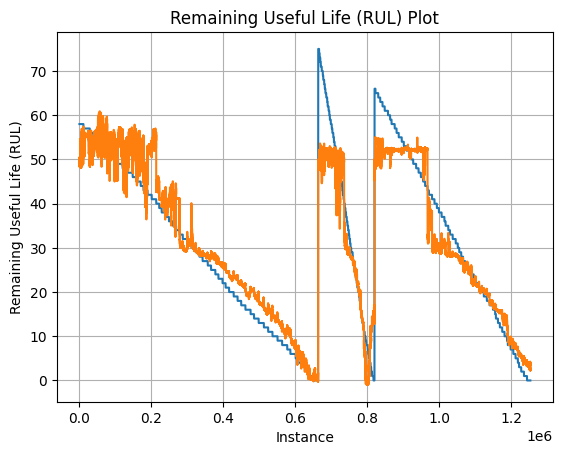

In [48]:
import matplotlib.pyplot as plt

# Example RUL values (replace with your actual data)
rul_values = val_actuals

# Create a figure and axis
fig, ax = plt.subplots()

# Plot RUL values as a line
ax.plot(val_actuals, marker='', linestyle='-')

ax.plot(val_predictions, marker='', linestyle='-')
# Customize plot
ax.set_xlabel('Instance')
ax.set_ylabel('Remaining Useful Life (RUL)')
ax.set_title('Remaining Useful Life (RUL) Plot')
ax.grid(True)

# Show plot
plt.show()


In [60]:
train_=train_.drop(columns=["fan_eff_mod","fan_flow_mod","LPC_eff_mod","LPC_flow_mod","HPC_flow_mod","HPC_eff_mod","HPT_flow_mod"])
train_

,T2,unit,cycle,Fc,hs,T24,T30,T48,T50,P15,...,W48,W50,SmFan,SmLPC,SmHPC,phi,HPT_eff_mod,LPT_eff_mod,LPT_flow_mod,RUL
2839273,503.721197,16.0,1.0,3.0,1.0,602.809026,1445.734091,1831.247582,1234.668125,16.004249,...,219.132512,231.882086,16.755149,9.826825,25.205333,42.167109,-0.000748,-0.000499,-0.000470,62
2839274,503.699197,16.0,1.0,3.0,1.0,602.884699,1445.729730,1830.328855,1233.775609,16.004450,...,219.145580,231.898897,16.747632,9.812432,25.243954,42.128645,-0.000748,-0.000499,-0.000470,62
2839275,503.682048,16.0,1.0,3.0,1.0,602.850026,1445.623942,1830.356293,1233.817761,15.999599,...,219.061447,231.810175,16.751288,9.804538,25.239399,42.133718,-0.000748,-0.000499,-0.000470,62
2839276,503.653483,16.0,1.0,3.0,1.0,602.817989,1445.560836,1830.231656,1233.717364,15.995012,...,219.009495,231.755178,16.751436,9.806258,25.240772,42.130588,-0.000748,-0.000499,-0.000470,62
2839277,503.645699,16.0,1.0,3.0,1.0,602.803554,1445.513032,1830.195152,1233.683058,15.992129,...,218.963946,231.706993,16.754685,9.804464,25.240621,42.130812,-0.000748,-0.000499,-0.000470,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3604563,502.759104,16.0,63.0,3.0,0.0,555.135733,1232.870547,1468.184069,1089.496435,13.519393,...,137.547188,145.687444,19.001082,6.042239,31.538067,34.080248,-0.008968,-0.005504,-0.017672,0
3604564,502.756750,16.0,63.0,3.0,0.0,554.678067,1229.818158,1459.263290,1084.383871,13.498591,...,136.681546,144.774412,18.987135,6.006830,31.808141,33.798049,-0.008968,-0.005504,-0.017672,0
3604565,502.770538,16.0,63.0,3.0,0.0,554.157953,1227.944149,1458.169108,1085.181024,13.476994,...,135.983569,144.034985,18.984340,6.002011,31.754596,33.824353,-0.008968,-0.005504,-0.017672,0
3604566,502.800780,16.0,63.0,3.0,0.0,553.690880,1224.529086,1448.463089,1079.716205,13.456842,...,135.009254,143.009394,18.971948,5.944589,32.050241,33.521120,-0.008968,-0.005504,-0.017672,0


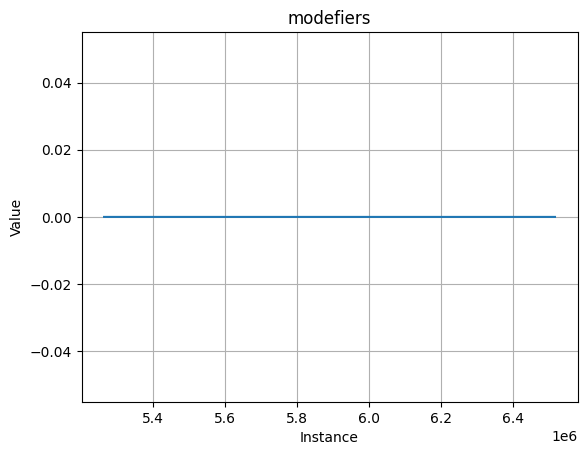

In [63]:
train_
import matplotlib.pyplot as plt

# Example RUL values (replace with your actual data)
rul_values = val_actuals

# Create a figure and axis
fig, ax = plt.subplots()

# Plot RUL values as a line
ax.plot(test_["HPT_flow_mod"], marker='', linestyle='-')


# Customize plot
ax.set_xlabel('Instance')
ax.set_ylabel('Value')
ax.set_title('modefiers')
ax.grid(True)

# Show plot
plt.show()

to drop=["fan_flow_mod","LPC_eff_mod","LPC_flow_mod","HPC_flow_mod","HPC_eff_mod","HPT_flow_mod]

In [67]:
test_=test_.drop(columns=["fan_eff_mod","fan_flow_mod","LPC_eff_mod","LPC_flow_mod","HPC_flow_mod","HPC_eff_mod","HPT_flow_mod"])

In [7]:
import pandas as pd
import numpy as np
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Trainer
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.metrics import QuantileLoss

# Sample data creation
# Assuming your data has columns: time_idx, target, and multiple features
data = pd.DataFrame({
    "time_idx": np.tile(np.arange(100), 10),
    "target": np.random.randn(1000),
    "group": np.repeat(np.arange(10), 100),
    "feature1": np.random.randn(1000),
    "feature2": np.random.randn(1000),
    "static_feature": np.repeat(np.random.randint(0, 10, 10), 100)
})

# Define the dataset
max_encoder_length = 30  # length of history
max_prediction_length = 10  # length of prediction horizon

training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[data.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="target",
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,  # allow up to 50% missing values in history
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group"],
    static_reals=["static_feature"],
    time_varying_known_reals=["time_idx", "feature1", "feature2"],
    time_varying_unknown_reals=["target"],
    target_normalizer=NaNLabelEncoder(),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# Create dataloaders for training and validation
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size)

# Define the Temporal Fusion Transformer model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # QuantileLoss has 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

# Train the model
trainer = Trainer(
    max_epochs=30,
    gpus=0  # set to >0 if you have a GPU
)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

# Make predictions
predictions = tft.predict(val_dataloader)


ImportError: cannot import name 'Trainer' from 'pytorch_forecasting' (c:\Users\lenovo legion\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_forecasting\__init__.py)

In [9]:
import pandas as pd
import numpy as np
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning import Trainer
# Sample data creation
# Assuming your data has columns: time_idx, target, and multiple features
data = pd.DataFrame({
    "time_idx": np.tile(np.arange(100), 10),
    "target": np.random.randn(1000),
    "group": np.repeat(np.arange(10), 100),
    "feature1": np.random.randn(1000),
    "feature2": np.random.randn(1000),
    "static_feature": np.repeat(np.random.randint(0, 10, 10), 100)
})

# Define the dataset
max_encoder_length = 30  # length of history
max_prediction_length = 10  # length of prediction horizon

training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[data.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="target",
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,  # allow up to 50% missing values in history
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group"],
    static_reals=["static_feature"],
    time_varying_known_reals=["time_idx", "feature1", "feature2"],
    time_varying_unknown_reals=["target"],
    target_normalizer=NaNLabelEncoder(),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# Create dataloaders for training and validation
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size)

# Define the Temporal Fusion Transformer model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # QuantileLoss has 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

# Train the model
trainer = Trainer(
    max_epochs=30,
    gpus=0  # set to >0 if you have a GPU
)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

# Make predictions
predictions = tft.predict(val_dataloader)


ValueError: Data type of category group was found to be numeric - use a string type / categorified string